In [31]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import layers
print('TensorFlow version:', tf.__version__)
print('Eager Execution Mode:', tf.executing_eagerly())
print('available GPU:', tf.config.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print('==========================================')
print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(False)

TensorFlow version: 2.4.0
Eager Execution Mode: True
available GPU: []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17346775989215899686
]


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
dataset_path = K.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path
#%%
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()
#%%
dataset = dataset.dropna()
#%%
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()
#%%
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#%%
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
#%%
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [34]:
def build_model():
    model = tf.keras.models.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model
#%%
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(K.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 200

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

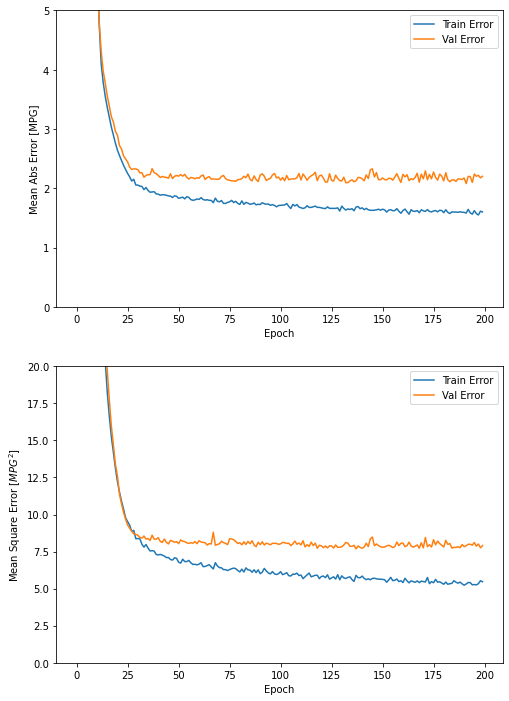

In [27]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

In [52]:
import shap

shap.initjs()

explainer_shap = shap.DeepExplainer(model=model,
                                    data=np.array(normed_train_data))

# Fit the explainer on a subset of the data (you can try all but then gets slower)
shap_values = explainer_shap.shap_values(X=np.array(normed_train_data),
                                        ranked_outputs=True)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [51]:
shap_values[0][0]

array([[ 0.01119625,  3.00030681,  2.18986405, ...,  0.99469201,
        -0.34335474, -0.10921763],
       [-0.09591106,  1.35168986,  0.68175643, ...,  0.50200688,
        -0.61170179, -0.17332433],
       [ 0.20115318, -3.17893708, -3.05536498, ...,  1.36121622,
        -0.68692474, -0.50701648],
       ...,
       [-0.97921701,  1.43030049,  0.00864765, ..., -0.97762747,
        -0.55714906,  1.84597442],
       [-0.93429331,  1.9021087 ,  3.56265258, ..., -0.32455522,
        -0.52484189,  1.70596323],
       [ 0.00624359,  1.60544172,  0.72760044, ..., -2.51248813,
         2.86060003, -0.58029743]])

In [53]:
'''i번째 관측치에 대해서 shap value 시각화'''
i = 0
shap.force_plot(explainer_shap.expected_value.numpy(),
                shap_values[0][0][i],
                np.array(normed_train_data)[i],
                feature_names=normed_train_data.columns)
'''
해석: weight가 작고, acceleration이 낮아 MPG가 높은 값이 예측됨
'''

In [56]:
np.array(normed_train_data)[i]

array([-0.86934805, -1.0094591 , -0.78405236, -1.0253028 , -0.3797592 ,
       -0.51639657,  0.77467638, -0.46514837, -0.49522541])

In [58]:
# shap value의 결과값과 일치
print(model.predict(np.array(normed_train_data)[[i]]))

[[-0.09546152]]


In [61]:
'''모든 관측치에 대해서 shap value를 누적하여 시각화'''
shap.force_plot(explainer_shap.expected_value.numpy(),
                shap_values[0][0],
                feature_names=normed_train_data.columns)

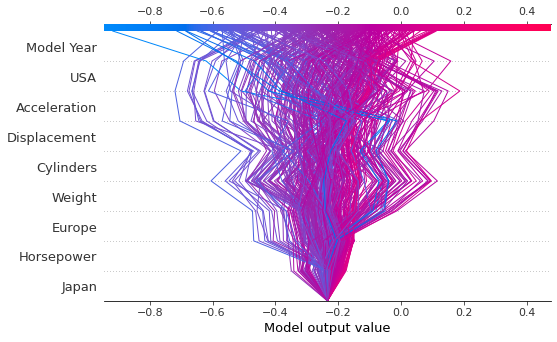

In [63]:
'''각 관측치들이 f(x)의 전체 평균에서 시작하여 각 predictor의 값에 따라 어떻게 예측값이 결정되는지(decision) 보여주는 그림'''
shap.decision_plot(explainer_shap.expected_value.numpy(),
                    shap_values[0][0],
                    np.array(normed_train_data),
                    feature_names=normed_train_data.columns.to_list())

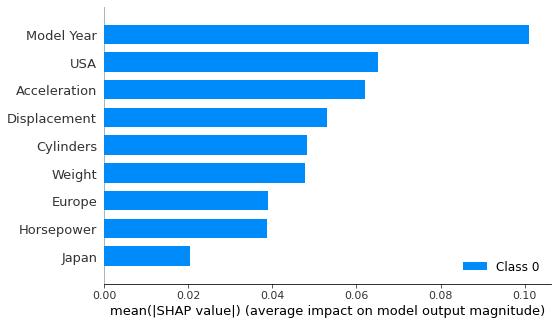

In [64]:
'''각 predictor들의 shap value의 절댓값 평균 -> 모형에 대한 평균적인 기여도'''
# get the ovearall mean contribution of each feature variable
shap.summary_plot(shap_values[0], np.array(normed_train_data), feature_names=normed_train_data.columns)